In [59]:
import numpy as np
import json
import pandas as pd
from collections import Counter
%matplotlib inline
import scipy as sp
from scipy import concatenate
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import sklearn
from sklearn.preprocessing import Imputer
from sklearn.metrics import confusion_matrix
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics
from sklearn.svm import LinearSVC
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import Ridge
from sklearn.grid_search import GridSearchCV
pd.options.display.max_columns = 100

#Data Exploration

Using the data that we already have, we clean it in order to run a Random Forest. First, we create a new column that identifies the data by year (Later on, we are going to fit the model to the 2013 data and predict on the 2014 data). We create a dictionary of PLAYER1_ID and TEAM_ID, in case we need to access these values later.

In [2]:
data_2014 = pd.read_csv("merged_shots/merged_shots_14.csv")
data_2013 = pd.read_csv("merged_shots/merged_shots_13.csv")

In [5]:
data_2014['YEAR'] = 2014
data_2013['YEAR'] = 2013

In [6]:
frames = [data_2013,data_2014]
combined = pd.concat(frames)

combined["unique"] = range(0,len(combined))
for i, c in enumerate(combined.isnull().sum()/combined.shape[0]):
    if c != 0:
        print combined.columns[i], c

HOMEDESCRIPTION 0.471027036451
NEUTRALDESCRIPTION 1.0
PLAYER2_NAME 0.735540915827
PLAYER2_TEAM_ABBREVIATION 0.735540915827
PLAYER2_TEAM_CITY 0.735540915827
PLAYER2_TEAM_ID 0.735540915827
PLAYER2_TEAM_NICKNAME 0.735540915827
PLAYER3_NAME 0.943737780047
PLAYER3_TEAM_ABBREVIATION 0.943737780047
PLAYER3_TEAM_CITY 0.943737780047
PLAYER3_TEAM_ID 0.943737780047
PLAYER3_TEAM_NICKNAME 0.943737780047
SCORE 0.548056638314
VISITORDESCRIPTION 0.472710743596
HOME_TEAM_ID 0.0979165369432
AWAY_TEAM_ID 0.0979165369432
HOME_PLAYER1_ID 0.0979165369432
HOME_PLAYER2_ID 0.0979165369432
HOME_PLAYER3_ID 0.0979165369432
HOME_PLAYER4_ID 0.0979165369432
HOME_PLAYER5_ID 0.0979165369432
AWAY_PLAYER1_ID 0.0979165369432
AWAY_PLAYER2_ID 0.0979165369432
AWAY_PLAYER3_ID 0.0979165369432
AWAY_PLAYER4_ID 0.0979165369432
AWAY_PLAYER5_ID 0.0979165369432
SHOT_CLOCK 0.0519234361574
off_height 0.0205556731715
def_height 0.0239355409158


In [7]:
a = np.concatenate((combined.PLAYER1_NAME, combined.PLAYER2_NAME))
b = np.concatenate((combined.PLAYER1_ID, combined.PLAYER2_ID))

In [8]:
player_id_dict = {k : v for k, v in zip(b, a)}
team_id_dict = {int(k) : v1+" "+v2 for k, v1, v2 in zip(combined.PLAYER1_TEAM_ID, combined.PLAYER1_TEAM_CITY, combined.PLAYER1_TEAM_NICKNAME)}

In [9]:
defender_id_dict = {int(k) : v for k, v in zip(combined.CLOSEST_DEFENDER_PLAYER_ID, combined.CLOSEST_DEFENDER)}

In [10]:
for p in defender_id_dict.keys():
    temp = p in player_id_dict.keys()
    if not temp:
        splt = defender_id_dict[p].split(",")
        player_id_dict[p] = splt[1]+" "+splt[0]

In [11]:
for i, c in enumerate(combined.columns):
        print i, ":", c

0 : Unnamed: 0
1 : EVENTMSGACTIONTYPE
2 : EVENTMSGTYPE
3 : EVENTNUM
4 : GAME_ID
5 : HOMEDESCRIPTION
6 : NEUTRALDESCRIPTION
7 : PCTIMESTRING
8 : PERIOD_x
9 : PERSON1TYPE
10 : PERSON2TYPE
11 : PERSON3TYPE
12 : PLAYER1_ID
13 : PLAYER1_NAME
14 : PLAYER1_TEAM_ABBREVIATION
15 : PLAYER1_TEAM_CITY
16 : PLAYER1_TEAM_ID
17 : PLAYER1_TEAM_NICKNAME
18 : PLAYER2_ID
19 : PLAYER2_NAME
20 : PLAYER2_TEAM_ABBREVIATION
21 : PLAYER2_TEAM_CITY
22 : PLAYER2_TEAM_ID
23 : PLAYER2_TEAM_NICKNAME
24 : PLAYER3_ID
25 : PLAYER3_NAME
26 : PLAYER3_TEAM_ABBREVIATION
27 : PLAYER3_TEAM_CITY
28 : PLAYER3_TEAM_ID
29 : PLAYER3_TEAM_NICKNAME
30 : SCORE
31 : SCOREMARGIN
32 : VISITORDESCRIPTION
33 : WCTIMESTRING
34 : HOME_TEAM_ID
35 : AWAY_TEAM_ID
36 : HOME_PLAYER1_ID
37 : HOME_PLAYER2_ID
38 : HOME_PLAYER3_ID
39 : HOME_PLAYER4_ID
40 : HOME_PLAYER5_ID
41 : AWAY_PLAYER1_ID
42 : AWAY_PLAYER2_ID
43 : AWAY_PLAYER3_ID
44 : AWAY_PLAYER4_ID
45 : AWAY_PLAYER5_ID
46 : ACTION_BEFORE
47 : Unnamed: 0.1
48 : CLOSEST_DEFENDER
49 : CLOSEST_D

In [12]:
col_dict = {x: col for x, col in enumerate(combined.columns)}
col_list = [0,1,2,4,5,6,7,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,32,33,34,35,36,37,38,39,40,41,42,43,44,45,47,48,49,52,53,54,55,57,58,59,60,63,65,67,71,68,76,73,78,79,80,81,85,90]
drop = [col_dict[x] for x in col_list]

In [40]:
combined_ = combined.drop(drop, axis=1)

In [14]:
for i, c in enumerate(combined_.columns):
        print i, ":", c

0 : EVENTNUM
1 : PERIOD_x
2 : SCOREMARGIN
3 : ACTION_BEFORE
4 : CLOSE_DEF_DIST
5 : DRIBBLES
6 : LOCATION
7 : PTS_TYPE
8 : SHOT_CLOCK
9 : SHOT_NUMBER
10 : TOUCH_TIME
11 : GAME_EVENT_ID
12 : PLAYER_ID
13 : PLAYER_NAME
14 : MINUTES_REMAINING
15 : SECONDS_REMAINING
16 : ACTION_TYPE
17 : SHOT_DISTANCE
18 : LOC_X
19 : LOC_Y
20 : SHOT_MADE_FLAG
21 : off_height
22 : def_height
23 : YEAR


In [15]:
def height(thing):
    try:
        f, i = thing.split('-')
    except AttributeError:
        return None
    except ValueError:
        return None
    else:
        return int(f)*12+int(i)

In [16]:
combined_['SEC_LEFT_Q'] = combined_.MINUTES_REMAINING*60+combined_.SECONDS_REMAINING
combined_['SEC_LEFT_G'] = np.where(combined_.PERIOD_x < 5, combined_.SEC_LEFT_Q+720*(4-combined_.PERIOD_x), combined_.SEC_LEFT_Q)
combined_.LOCATION = np.where(combined_.LOCATION == "H", 1, 0)
combined_['OFF_HEIGHT'] = combined.off_height.apply(lambda x: height(x))
combined_['DEF_HEIGHT'] = combined.def_height.apply(lambda x: height(x))
combined_['HEIGHT_DIFF'] = combined_['OFF_HEIGHT'] - combined_['DEF_HEIGHT']
combined_['JUMP_SHOT']=[1 if x=='Jump Shot' else 0 for x in combined_.ACTION_TYPE]
combined_['SHOT_DISTxCLOSE_DEF_DIST'] = combined_['SHOT_DISTANCE']*combined_['CLOSE_DEF_DIST']
combined_['HEIGHTxCLOSE_DEF_DIST'] = combined_['HEIGHT_DIFF']*combined_['CLOSE_DEF_DIST']
combined_['SHOT_DISTxJUMP_SHOT']= combined_['SHOT_DISTANCE']*combined_['JUMP_SHOT']
combined_['NO_DRIBBLE'] = combined_.DRIBBLES == 0
action = pd.get_dummies(combined_['ACTION_TYPE']).ix[:,1:]
frames = [combined_, action]
combined_ = pd.concat(frames, axis=1)

In [17]:
del combined_['MINUTES_REMAINING']
del combined_['SECONDS_REMAINING']
del combined_['off_height']
del combined_['def_height']
del combined_['JUMP_SHOT']

In [18]:
combined_.reset_index(drop=True, inplace=True)
combined_.head()

EVENTNUM  PERIOD_x  SCOREMARGIN  ACTION_BEFORE  CLOSE_DEF_DIST  DRIBBLES  \
0         2         1            0             10             1.6         2   
1         5         1            2              6             4.1         1   
2         6         1           -2              1             4.4         0   
3         8         1            2              4             0.4         0   
4        11         1            5              5             5.7         0   

   LOCATION  PTS_TYPE  SHOT_CLOCK  SHOT_NUMBER  TOUCH_TIME  GAME_EVENT_ID  \
0         1         2         6.7            1         7.8              2   
1         1         2        16.8            1         3.2              5   
2         0         3        13.0            1         0.7              6   
3         1         2        13.8            2         1.8              8   
4         1         3        15.6            1         0.7             11   

   PLAYER_ID       PLAYER_NAME       ACTION_TYPE  SHOT_DISTANCE  LOC_X  LOC_Y  \
0       2561        David West         Jump Shot              5    -38     45   
1     202331       Paul George  Pullup Jump shot             19    105    164   
2     201167     Arron Afflalo         Jump Shot             27     51    266   
3       2561        David West        Layup Shot              2     28     -5   
4     202362  Lance Stephenson         Jump Shot             26     15    260   

   SHOT_MADE_FLAG  YEAR  SEC_LEFT_Q  SEC_LEFT_G  OFF_HEIGHT  DEF_HEIGHT  \
0               0  2013         699        2859          81          79   
1               1  2013         690        2850          81          81   
2               0  2013         675        2835          77          81   
3               0  2013         663        2823          81          79   
4               1  2013         651        2811          77          72   

   HEIGHT_DIFF  SHOT_DISTxCLOSE_DEF_DIST  HEIGHTxCLOSE_DEF_DIST  \
0            2                       8.0                    3.2   
1            0                      77.9                    0.0   
2           -4                     118.8                  -17.6   
3            2                       0.8                    0.8   
4            5                     148.2                   28.5   

   SHOT_DISTxJUMP_SHOT NO_DRIBBLE  Alley Oop Layup shot  \
0                    5      False                     0   
1                    0      False                     0   
2                   27       True                     0   
3                    0       True                     0   
4                   26       True                     0   

   Driving Bank Hook Shot  Driving Bank shot  Driving Dunk Shot  \
0                       0                  0                  0   
1                       0                  0                  0   
2                       0                  0                  0   
3                       0                  0                  0   
4                       0                  0                  0   

   Driving Finger Roll Layup Shot  Driving Hook Shot  Driving Jump shot  \
0                               0                  0                  0   
1                               0                  0                  0   
2                               0                  0                  0   
3                               0                  0                  0   
4                               0                  0                  0   

   Driving Layup Shot  Driving Reverse Layup Shot  Driving Slam Dunk Shot  \
0                   0                           0                       0   
1                   0                           0                       0   
2                   0                           0                       0   
3                   0                           0                       0   
4                   0                           0                       0   

   Dunk Shot  Fadeaway Bank shot  Fadeaway Jump Shot

In [19]:
combined_.to_csv('parsed_df.csv')

In [20]:
player_id_dict = {k : v for k, v in zip(b, a)}
team_id_dict = {int(k) : v1+" "+v2 for k, v1, v2 in zip(combined.PLAYER1_TEAM_ID, combined.PLAYER1_TEAM_CITY, combined.PLAYER1_TEAM_NICKNAME)}

In [22]:
pd.DataFrame([[k,v] for k, v in player_id_dict.iteritems()], columns=["ID", "NAME"]).to_json('Player_ID_Dict.json')
pd.DataFrame([[k,v] for k, v in team_id_dict.iteritems()], columns=["ID", "NAME"]).to_json('Team_ID_Dict.json')

In [24]:
df=pd.read_csv("parsed_df.csv")
del df['Unnamed: 0']
del df['ACTION_TYPE']
del df['PLAYER_ID']

In [25]:
#drop all rows with NaN values
df = df.dropna()

In [26]:
cols = list(df)
cols.insert(0, cols.pop(cols.index('SHOT_MADE_FLAG')))
df = df.ix[:, cols]

In [27]:
dftouse=df.copy()
dftouse=dftouse.dropna()
dftouse=dftouse.sample(30000, replace=False)

In [41]:
Xnames = list(dftouse.columns.values[1:76])
Xnames.remove('PLAYER_NAME')
Xnames

['EVENTNUM',
 'PERIOD_x',
 'SCOREMARGIN',
 'ACTION_BEFORE',
 'CLOSE_DEF_DIST',
 'DRIBBLES',
 'LOCATION',
 'PTS_TYPE',
 'SHOT_CLOCK',
 'SHOT_NUMBER',
 'TOUCH_TIME',
 'GAME_EVENT_ID',
 'SHOT_DISTANCE',
 'LOC_X',
 'LOC_Y',
 'YEAR',
 'SEC_LEFT_Q',
 'SEC_LEFT_G',
 'OFF_HEIGHT',
 'DEF_HEIGHT',
 'HEIGHT_DIFF',
 'SHOT_DISTxCLOSE_DEF_DIST',
 'HEIGHTxCLOSE_DEF_DIST',
 'SHOT_DISTxJUMP_SHOT',
 'NO_DRIBBLE',
 'Alley Oop Layup shot',
 'Driving Bank Hook Shot',
 'Driving Bank shot',
 'Driving Dunk Shot',
 'Driving Finger Roll Layup Shot',
 'Driving Hook Shot',
 'Driving Jump shot',
 'Driving Layup Shot',
 'Driving Reverse Layup Shot',
 'Driving Slam Dunk Shot',
 'Dunk Shot',
 'Fadeaway Bank shot',
 'Fadeaway Jump Shot',
 'Finger Roll Layup Shot',
 'Floating Jump shot',
 'Hook Bank Shot',
 'Hook Shot',
 'Jump Bank Hook Shot',
 'Jump Bank Shot',
 'Jump Hook Shot',
 'Jump Shot',
 'Layup Shot',
 'Pullup Bank shot',
 'Pullup Jump shot',
 'Putback Dunk Shot',
 'Putback Layup Shot',
 'Putback Reverse Dunk S

In [32]:
#create train and test set
from sklearn.cross_validation import train_test_split
itrain, itest = train_test_split(xrange(dftouse.shape[0]), train_size=0.7)
mask=np.ones(dftouse.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [33]:
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    best = gs.best_estimator_
    return best

def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5, n_jobs=1):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    y_=indf[targetname]
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

In [34]:
clfForest = RandomForestClassifier()
parameters = {
    "n_estimators" : [10,50,100,500,1000],
    #"n_estimators" : range(1, 21),
    #"max_features" : range(10,len(Xnames+1),2)
    "max_depth": [100,200,400,800],
    #"bootstrap": [True, False]
    }

In [35]:
%%time
clfForest, Xtrain, ytrain, Xtest, ytest = do_classify(clfForest, parameters, dftouse, Xnames, 'SHOT_MADE_FLAG', 1, mask=mask, n_folds = 5, n_jobs = 4, score_func='f1')

using mask


/Users/raymondcen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


BEST {'n_estimators': 500, 'max_depth': 400} 0.580071002756 [mean: 0.52181, std: 0.00906, params: {'n_estimators': 10, 'max_depth': 100}, mean: 0.56861, std: 0.00857, params: {'n_estimators': 50, 'max_depth': 100}, mean: 0.57372, std: 0.00676, params: {'n_estimators': 100, 'max_depth': 100}, mean: 0.57871, std: 0.01149, params: {'n_estimators': 500, 'max_depth': 100}, mean: 0.57952, std: 0.01028, params: {'n_estimators': 1000, 'max_depth': 100}, mean: 0.51687, std: 0.01240, params: {'n_estimators': 10, 'max_depth': 200}, mean: 0.56729, std: 0.00894, params: {'n_estimators': 50, 'max_depth': 200}, mean: 0.57336, std: 0.01508, params: {'n_estimators': 100, 'max_depth': 200}, mean: 0.57797, std: 0.01318, params: {'n_estimators': 500, 'max_depth': 200}, mean: 0.57968, std: 0.01191, params: {'n_estimators': 1000, 'max_depth': 200}, mean: 0.52590, std: 0.01245, params: {'n_estimators': 10, 'max_depth': 400}, mean: 0.56682, std: 0.01256, params: {'n_estimators': 50, 'max_depth': 400}, mean: 0

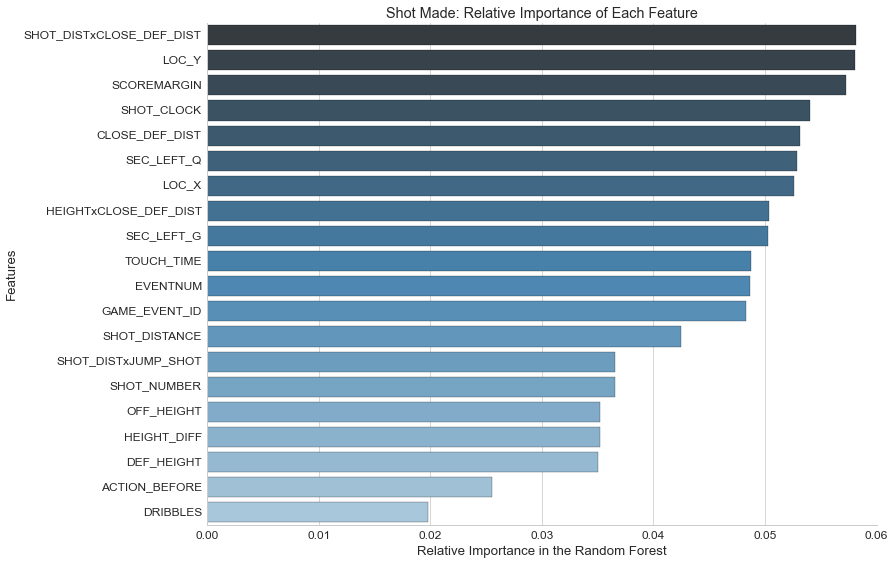

In [36]:
importance_list = clfForest.feature_importances_
name_list = dftouse.columns
importance_list, name_list = zip(*sorted(zip(importance_list, Xnames)))
#full list of features
#ax = sns.barplot(y=range(len(name_list)),x=list(reversed(importance_list)), orient='h', palette="Blues_d")
sns.set_context("paper", font_scale=1.5)
plt.figure(figsize=(12, 9))
#top 20 features
ax = sns.barplot(y=range(20),x=list(reversed(importance_list))[:20], orient='h', palette="Blues_d")
ax.set_xlabel('Relative Importance in the Random Forest')
ax.set_ylabel('Features')
ax.set_title('Shot Made: Relative Importance of Each Feature')
ax.set_yticklabels(list(reversed(name_list)));
sns.despine()
plt.savefig('Baseline Relative Importance.png', bbox_inches='tight')

In [47]:
df2013 = df[df['YEAR']==2013]
df2014 = df[df['YEAR']==2014]
#df2013.reset_index(drop=True, inplace=True)
df2013_ = df2013.drop('PLAYER_NAME', axis=1)
df2014_ = df2014.drop('PLAYER_NAME', axis=1)
Xtrain2013 = df2013_.ix[:, 1:76]
ytrain2013 = df2013_['SHOT_MADE_FLAG']
Xtest2014 = df2014_.ix[:, 1:76]

In [49]:
%%time
clfForest.fit(Xtrain2013, ytrain2013)

CPU times: user 5min 3s, sys: 5.13 s, total: 5min 8s
Wall time: 5min 10s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=400, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [50]:
%%time
predictions = clfForest.predict_proba(Xtest2014)

CPU times: user 40 s, sys: 7.55 s, total: 47.5 s
Wall time: 56.1 s


In [52]:
df2014['pred']=[x[1] for x in predictions]
df2014['resid']=(df2014.SHOT_MADE_FLAG-df2014.pred)*df2014.PTS_TYPE
players=list(set(df2014['PLAYER_NAME']))
pct_above=[]
predpps=[]
count=[]
players_act=[]
for player in players:
    subset=df2014[df2014['PLAYER_NAME']==player]
    if len(subset.index)>100:
        players_act.append(player)
        pct_above.append(np.average(subset.resid))
        predpps.append(np.average(subset.pred*subset.PTS_TYPE))
        count.append(len(subset.index))

/Users/raymondcen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/raymondcen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [56]:
MSE = np.average([(x-y)**2 for x,y in zip(df2014.SHOT_MADE_FLAG,df2014.pred)])
print 'MSE: ' + str(MSE)

MSE: 0.211309295305


In [57]:
Accuracy = np.average([1 if (x-.5)*(y-.5)>0 else 0 for x,y in zip(df2014.SHOT_MADE_FLAG,df2014.pred)])
print 'Accuracy: ' + str(Accuracy)

Accuracy: 0.661577472592


In [58]:
comb=zip(players_act,pct_above,predpps,count)
comb.sort(key=lambda tup: tup[1],reverse=True)
comb

[('Luke Babbitt', 0.28128176795580112, 0.99496132596685061, 181),
 ('Kyle Korver', 0.20643761301989147, 1.1244846292947559, 553),
 ('Andre Miller', 0.19506563706563709, 0.83582239382239387, 259),
 ('Damjan Rudez', 0.17525896414342629, 1.0000398406374502, 251),
 ('Ed Davis', 0.16554404145077722, 1.1038860103626944, 386),
 ('Chris Paul', 0.15883576642335767, 0.94791605839416049, 1096),
 ('George Hill', 0.15442561983471073, 0.93648347107438012, 484),
 ('CJ Watson', 0.14877165354330704, 0.94309186351706031, 381),
 ('Al Jefferson', 0.14482131661442005, 0.83636990595611282, 957),
 ('Hedo Turkoglu', 0.13931868131868133, 1.0804615384615386, 182),
 ('Carl Landry', 0.13375498575498579, 0.91467806267806273, 351),
 ('TJ Warren', 0.13022772277227726, 0.99353465346534653, 202),
 ('Ben Gordon', 0.12482397003745317, 0.91262921348314607, 267),
 ('Anthony Morrow', 0.12284869565217392, 1.0545426086956522, 575),
 ('David West', 0.11719637462235651, 0.83295468277945628, 662),
 ('Jose Calderon', 0.113562130